In [17]:
import pandas as pd
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

In [18]:
# Đọc dữ liệu
df = pd.read_csv("household_power_consumption.csv", sep=',')
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format="%d/%m/%Y %H:%M:%S")

# Ép kiểu số
cols = [
    'Global_active_power', 'Global_reactive_power', 'Voltage',
    'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'
]
for col in cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df.set_index('datetime', inplace=True)
df = df.dropna()

In [19]:
# Resample để giảm độ phức tạp: lấy trung bình mỗi 10 phút
df_sample = df[[
    'Global_active_power', 'Global_reactive_power', 'Voltage',
    'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'
]].resample('10min').mean().dropna().iloc[:500]

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_sample)

# Chuẩn hóa riêng cho Global_active_power (để dùng cho GPR và inverse transform)
scaler_y = StandardScaler()
y = df_sample['Global_active_power'].values
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()

In [26]:
# Hàm tạo sequence cho Transformer
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 0])  # Dự đoán Global_active_power
    return np.array(X), np.array(y)

# Tham số cho Transformer
sequence_length = 12  # 60 phút (6 timesteps của 10 phút)
n_features = df_sample.shape[1]  # Số lượng đặc trưng (7 cột)

# Tạo sequence
X_seq, y_seq = create_sequences(scaled_data, sequence_length)

# Chia dữ liệu train/test
train_size = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

In [27]:
# Định nghĩa mô hình Transformer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Multi-head attention
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)
    
    # Feed-forward
    ff = layers.Dense(ff_dim, activation="relu")(x)
    ff = layers.Dense(inputs.shape[-1])(ff)
    ff = layers.Dropout(dropout)(ff)
    return layers.LayerNormalization(epsilon=1e-6)(ff + x)

In [28]:
# Xây dựng mô hình
inputs = layers.Input(shape=(sequence_length, n_features))
x = transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = models.Model(inputs, outputs)

# Biên dịch và huấn luyện
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Dự đoán với Transformer
y_pred_transformer_scaled = model.predict(X_test)
y_pred_transformer = scaler_y.inverse_transform(y_pred_transformer_scaled)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.7119 - val_loss: 1.1807
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4133 - val_loss: 1.0435
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3439 - val_loss: 1.0018
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2975 - val_loss: 0.9966
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3086 - val_loss: 0.9852
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3200 - val_loss: 0.9822
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3145 - val_loss: 0.9806
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3360 - val_loss: 0.9880
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3024 - val_loss: 1.0171
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3196 - val_loss: 0.9784
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2674 - val_loss: 1.0228
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2153 - val_l

In [29]:
# Gaussian Process Regression (từ code của bạn)
X_gpr = (df_sample.index.astype(np.int64) // 10**9 // 60).values.reshape(-1, 1)
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, alpha=0.1)
gp.fit(X_gpr, y_scaled)
y_pred_gpr_scaled, sigma = gp.predict(X_gpr, return_std=True)
y_pred_gpr = scaler_y.inverse_transform(y_pred_gpr_scaled.reshape(-1, 1)).ravel()

# Chuẩn bị dữ liệu để vẽ (cắt dữ liệu thực tế tương ứng với test set của Transformer)
test_indices = df_sample.index[sequence_length:sequence_length + len(y_test)]
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()

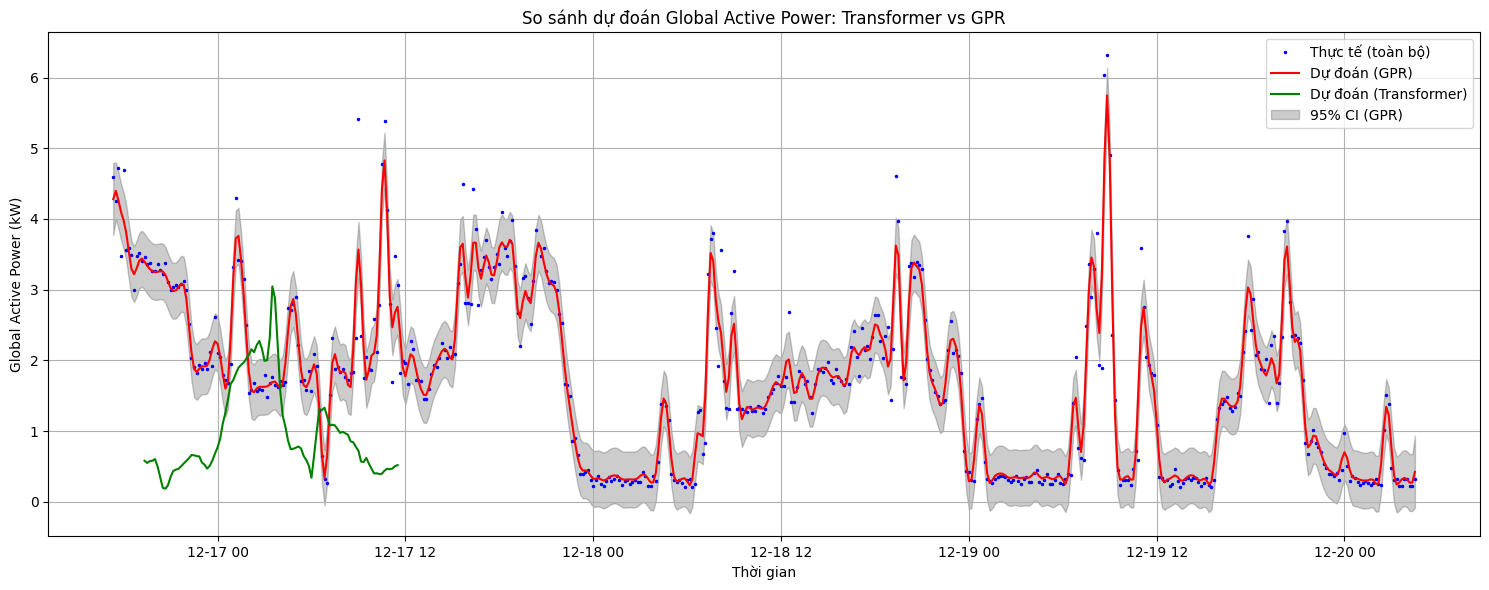

In [30]:
# Vẽ biểu đồ so sánh
plt.figure(figsize=(15, 6))
plt.plot(df_sample.index, y, 'b.', markersize=3, label='Thực tế (toàn bộ)')
plt.plot(df_sample.index, y_pred_gpr, 'r-', label='Dự đoán (GPR)')
plt.plot(test_indices, y_pred_transformer, 'g-', label='Dự đoán (Transformer)')
plt.fill_between(df_sample.index,
                 y_pred_gpr - 1.96 * sigma,
                 y_pred_gpr + 1.96 * sigma,
                alpha=0.2, color='k', label='95% CI (GPR)')
plt.xlabel('Thời gian')
plt.ylabel('Global Active Power (kW)')
plt.title('So sánh dự đoán Global Active Power: Transformer vs GPR')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
print("Transformer Test MSE:", model.evaluate(X_test, y_test))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2326 
Transformer Test MSE: 0.24605770409107208
